# Session 3: Centrality Measures in Financial Networks

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Session Goals:**
By the end of this session, you will:
1. Master multiple centrality measures and their interpretations
2. Understand when to use which centrality metric
3. Apply centrality analysis to identify systemically important institutions
4. Compare centrality-based rankings with traditional size measures

**Practical Application:**
Identify key players in cryptocurrency markets using multi-centrality analysis

**Duration:** 3 hours

---


## Motivation: Why Centrality Matters

### The Fundamental Question

**In any network:** Which nodes are most important?

This seemingly simple question has **many different answers** depending on what "important" means:

- **Most connected?** (degree centrality)
- **Most influential?** (eigenvector centrality)
- **Best positioned to control information flow?** (betweenness centrality)
- **Closest to all others?** (closeness centrality)
- **Most prestigious?** (PageRank)

### Financial Examples

**Banking Networks:**
- Which institutions pose greatest systemic risk?
- Which banks are "too interconnected to fail"?
- Where should regulators focus supervision?

**Trade Networks:**
- Which countries are key intermediaries?
- Who controls global supply chains?
- Where are bottlenecks?

**Cryptocurrency Markets:**
- Which tokens drive market sentiment?
- Which are information hubs vs price followers?
- Where do shocks originate?

### Why Multiple Measures?

**Different centralities capture different types of importance!**

Consider two banks:
- **Bank A:** Lends to 100 small institutions
- **Bank B:** Lends to 3 major central hubs

Who is more important?
- **Degree:** Bank A (more connections)
- **Eigenvector:** Bank B (connected to important nodes)

**The answer depends on the question!**

Let's explore each measure systematically.


---
## Setup and Imports


In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, linalg
from scipy.spatial.distance import pdist, squareform

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibility
np.random.seed(42)

print("✓ Environment configured successfully!")
print(f"  NumPy version: {np.__version__}")
print(f"  NetworkX version: {nx.__version__}")
print(f"  Pandas version: {pd.__version__}")


✓ Environment configured successfully!
  NumPy version: 1.26.4
  NetworkX version: 3.2.1
  Pandas version: 2.2.2


---
# Part 1: Degree Centrality

## 1.1 Definition and Intuition

**Degree Centrality** is the simplest centrality measure: it counts connections.

### Mathematical Definition

For node $i$ in a network with $n$ nodes:

**Undirected networks:**
$$C_D(i) = k_i = \sum_{j=1}^n A_{ij}$$

**Normalized version:**
$$C_D^{\text{norm}}(i) = \frac{k_i}{n-1}$$

where $n-1$ is the maximum possible degree.

**Directed networks:**

**Out-degree centrality:** (outgoing connections)
$$C_D^{\text{out}}(i) = k_i^{\text{out}} = \sum_{j=1}^n A_{ij}$$

**In-degree centrality:** (incoming connections)
$$C_D^{\text{in}}(i) = k_i^{\text{in}} = \sum_{j=1}^n A_{ji}$$

### Interpretation

**High degree = High activity/connectivity**

**Financial contexts:**
- **Banking:** Number of counterparties
  - Out-degree: Number of borrowers (lending exposure)
  - In-degree: Number of lenders (funding sources)
- **Trade:** Number of trading partners
- **Cryptocurrencies:** Number of trading pairs

### Strengths and Limitations

**✓ Strengths:**
- Simple to compute and interpret
- Captures local connectivity
- Good proxy for immediate exposure

**✗ Limitations:**
- Ignores network structure beyond immediate neighbors
- Treats all connections equally (no quality distinction)
- Misses indirect influence
- A node connected to 100 unimportant nodes ranks higher than one connected to 3 central hubs

**Example where degree fails:**
- Social network: A person who knows 1000 random people vs one who knows 3 world leaders
- Degree says first person is more important (clearly wrong!)


In [4]:
# Example 1.1: Degree Centrality in Action

# Create a stylized interbank network
banks = ['JPMorgan', 'HSBC', 'Goldman', 'Deutsche', 'BNP', 
         'Citi', 'Barclays', 'UBS', 'Credit Suisse', 'Morgan Stanley']
n_banks = len(banks)

# Create directed lending network (billions USD)
np.random.seed(42)
A_lending = np.zeros((n_banks, n_banks))

# Core banks (highly interconnected)
core_banks = [0, 1, 2, 5, 6]  # JPM, HSBC, Goldman, Citi, Barclays

# Dense connections among core
for i in core_banks:
    for j in core_banks:
        if i != j:
            A_lending[i, j] = np.random.uniform(5, 20)

# Peripheral banks connect mainly to core
peripheral = [i for i in range(n_banks) if i not in core_banks]
for i in peripheral:
    # Connect to 2-3 core banks
    core_partners = np.random.choice(core_banks, size=np.random.randint(2, 4), replace=False)
    for j in core_partners:
        A_lending[i, j] = np.random.uniform(2, 8)
        A_lending[j, i] = np.random.uniform(3, 10)

print("INTERBANK LENDING NETWORK")
print("="*70)
print(f"Number of banks: {n_banks}")
print(f"Total lending relationships: {np.count_nonzero(A_lending)}")

# Compute degree centralities
out_degree = A_lending.sum(axis=1)  # Total lending
in_degree = A_lending.sum(axis=0)   # Total borrowing
total_degree = out_degree + in_degree

# Create DataFrame for better display
degree_df = pd.DataFrame({
    'Bank': banks,
    'Out-Degree (Lending)': out_degree,
    'In-Degree (Borrowing)': in_degree,
    'Total Degree': total_degree,
    'Net Position': out_degree - in_degree
})

# Sort by total degree
degree_df = degree_df.sort_values('Total Degree', ascending=False)

print("\nDegree Centrality Rankings:")
print("="*70)
print(degree_df.to_string(index=False))

print(f"\nKey Observations:")
print(f"  • Highest total degree: {degree_df.iloc[0]['Bank']} ({degree_df.iloc[0]['Total Degree']:.1f}B)")
print(f"  • Largest net lender: {degree_df.loc[degree_df['Net Position'].idxmax(), 'Bank']}")
print(f"  • Largest net borrower: {degree_df.loc[degree_df['Net Position'].idxmin(), 'Bank']}")


INTERBANK LENDING NETWORK
Number of banks: 10
Total lending relationships: 44

Degree Centrality Rankings:
          Bank  Out-Degree (Lending)  In-Degree (Borrowing)  Total Degree  Net Position
      JPMorgan             82.085181              63.631278    145.716459     18.453903
      Barclays             67.106965              75.691182    142.798147     -8.584216
       Goldman             75.962608              56.260916    132.223524     19.701691
          Citi             58.179569              50.321262    108.500831      7.858307
          HSBC             41.999455              50.318768     92.318223     -8.319313
Morgan Stanley             16.644203              24.812216     41.456419     -8.168013
           UBS             16.484114              16.170707     32.654821      0.313406
 Credit Suisse              8.229535              16.614064     24.843599     -8.384529
      Deutsche              6.838411              17.211318     24.049729    -10.372908
           BN

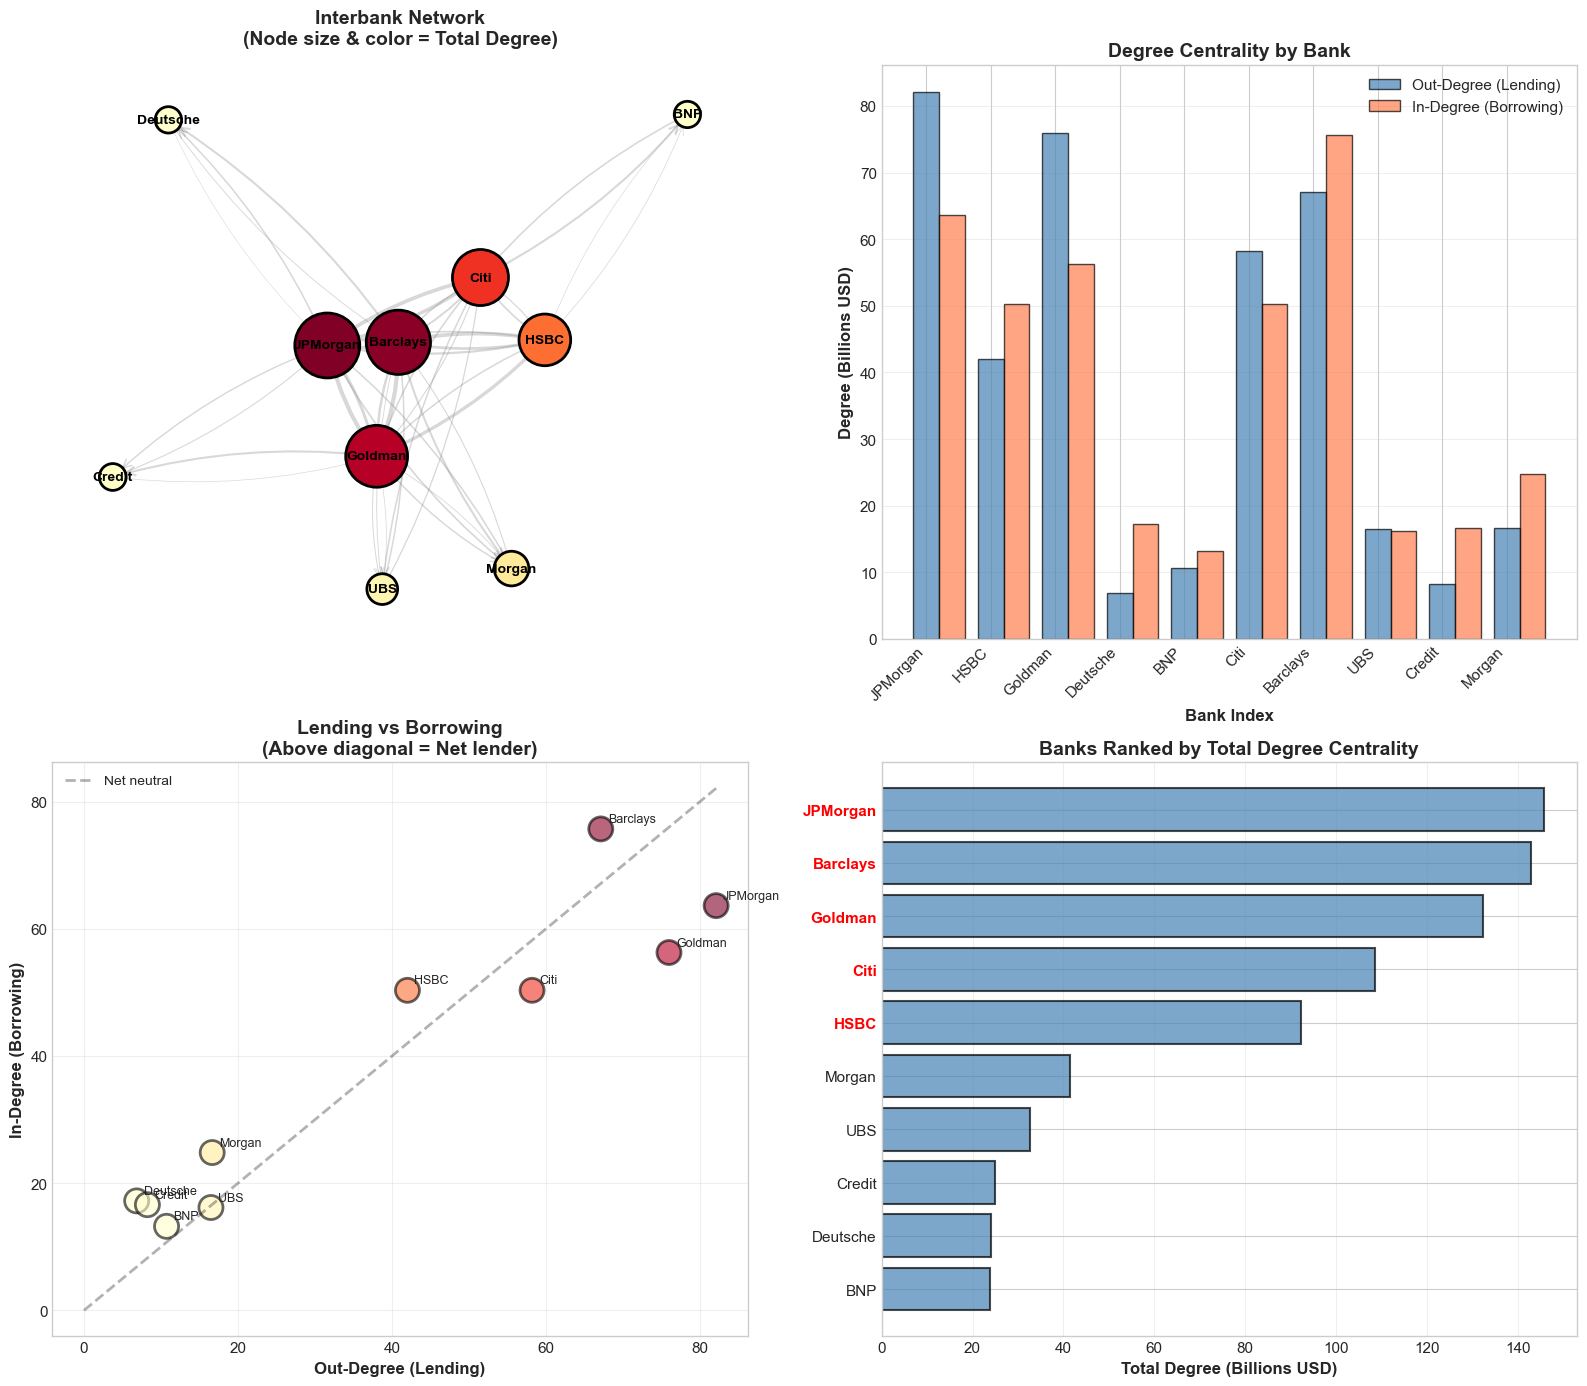


Interpretation:
• Red labels = Core banks (highly interconnected)
• Node size in network = Total lending + borrowing
• Banks above diagonal = Net lenders (systemic liquidity providers)
• Banks below diagonal = Net borrowers (liquidity dependent)


In [6]:
# Visualize degree centrality

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Network visualization
ax = axes[0, 0]
G = nx.DiGraph(A_lending)

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Node sizes proportional to total degree
node_sizes = [total_degree[i] * 15 for i in range(n_banks)]

# Draw
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
widths = [3 * w / max_weight for w in weights]

nx.draw_networkx_edges(G, pos, ax=ax, width=widths, alpha=0.3,
                       arrows=True, arrowsize=15, arrowstyle='->',
                       edge_color='gray', connectionstyle='arc3,rad=0.1')

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes,
                       node_color=total_degree, cmap='YlOrRd',
                       edgecolors='black', linewidths=2)

# Labels
labels = {i: banks[i].split()[0] for i in range(n_banks)}
nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=10, font_weight='bold')

ax.set_title('Interbank Network\n(Node size & color = Total Degree)',
             fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Plot 2: Degree distribution
ax = axes[0, 1]
ax.bar(range(n_banks), out_degree, width=0.4, alpha=0.7, 
       label='Out-Degree (Lending)', color='steelblue', edgecolor='black')
ax.bar(np.arange(n_banks) + 0.4, in_degree, width=0.4, alpha=0.7,
       label='In-Degree (Borrowing)', color='coral', edgecolor='black')

ax.set_xlabel('Bank Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Degree (Billions USD)', fontsize=12, fontweight='bold')
ax.set_title('Degree Centrality by Bank', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(n_banks))
ax.set_xticklabels([b.split()[0] for b in banks], rotation=45, ha='right')

# Plot 3: Scatter - In vs Out degree
ax = axes[1, 0]
ax.scatter(out_degree, in_degree, s=300, alpha=0.6, 
          c=total_degree, cmap='YlOrRd', edgecolors='black', linewidths=2)

# Add bank labels
for i, bank in enumerate(banks):
    ax.annotate(bank.split()[0], (out_degree[i], in_degree[i]),
               xytext=(5, 5), textcoords='offset points', fontsize=9)

# Diagonal line (net position = 0)
max_val = max(out_degree.max(), in_degree.max())
ax.plot([0, max_val], [0, max_val], 'k--', linewidth=2, alpha=0.3, label='Net neutral')

ax.set_xlabel('Out-Degree (Lending)', fontsize=12, fontweight='bold')
ax.set_ylabel('In-Degree (Borrowing)', fontsize=12, fontweight='bold')
ax.set_title('Lending vs Borrowing\n(Above diagonal = Net lender)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Ranking comparison
ax = axes[1, 1]
sorted_banks = degree_df['Bank'].values
y_pos = np.arange(len(sorted_banks))

ax.barh(y_pos, degree_df['Total Degree'].values, alpha=0.7,
       color='steelblue', edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels([b.split()[0] for b in sorted_banks], fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Total Degree (Billions USD)', fontsize=12, fontweight='bold')
ax.set_title('Banks Ranked by Total Degree Centrality',
            fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Highlight core banks
for i, bank in enumerate(sorted_banks):
    if bank in [banks[j] for j in core_banks]:
        ax.get_yticklabels()[i].set_color('red')
        ax.get_yticklabels()[i].set_weight('bold')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Red labels = Core banks (highly interconnected)")
print("• Node size in network = Total lending + borrowing")
print("• Banks above diagonal = Net lenders (systemic liquidity providers)")
print("• Banks below diagonal = Net borrowers (liquidity dependent)")


---
# Part 2: Betweenness Centrality

## 2.1 Definition and Intuition

**Betweenness Centrality** measures how often a node lies on shortest paths between other nodes.

**Key idea:** Control over information/resource flow

### Mathematical Definition

For node $i$:

$$C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$$

where:
- $\sigma_{st}$ = total number of shortest paths from $s$ to $t$
- $\sigma_{st}(i)$ = number of those paths that pass through $i$

**Normalized version:**
$$C_B^{\text{norm}}(i) = \frac{C_B(i)}{(n-1)(n-2)/2}$$

where $(n-1)(n-2)/2$ is the maximum possible betweenness.

### Interpretation

**High betweenness = Bridge or bottleneck**

**Node with high betweenness:**
- Sits on many shortest paths
- Controls flow between different parts of network
- Removal disconnects or lengthens paths
- **Critical for network cohesion**

**Financial contexts:**
- **Banking:** Intermediaries in lending chains
- **Trade:** Countries that facilitate indirect trade
- **Payments:** Key nodes in transaction routing
- **Information:** Brokers between market segments

### Example: Bridge vs Hub

Consider two networks:

**Star network:**
- Center node: High degree, high betweenness
- Peripheral nodes: Low degree, zero betweenness

**Chain network:**
- Middle nodes: Low degree, high betweenness  
- End nodes: Degree 1, zero betweenness

**Key insight:** Betweenness ≠ Degree!

### Strengths and Limitations

**✓ Strengths:**
- Identifies bridges and bottlenecks
- Captures strategic position in network
- Important for contagion and fragility
- Reveals vulnerability points

**✗ Limitations:**
- Computationally expensive: $O(n^3)$ for dense graphs
- Assumes shortest paths (may not reflect actual flows)
- Doesn't account for edge weights (in basic version)
- Can be low even for important nodes (e.g., in dense networks)


In [9]:
# Example 2.1: Betweenness Centrality

# We'll use the same interbank network
G_lending = nx.DiGraph(A_lending)

print("BETWEENNESS CENTRALITY ANALYSIS")
print("="*70)

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G_lending, normalized=True)
betweenness_values = np.array([betweenness[i] for i in range(n_banks)])

# Compare with degree
comparison_df = pd.DataFrame({
    'Bank': banks,
    'Degree Centrality': total_degree / total_degree.max(),
    'Betweenness Centrality': betweenness_values,
    'Total Degree': total_degree,
    'Betweenness Rank': stats.rankdata(-betweenness_values, method='ordinal'),
    'Degree Rank': stats.rankdata(-total_degree, method='ordinal')
})

# Sort by betweenness
comparison_df = comparison_df.sort_values('Betweenness Centrality', ascending=False)

print("\nCentrality Comparison (Sorted by Betweenness):")
print("="*70)
print(comparison_df.to_string(index=False))

# Identify disagreements
rank_diff = np.abs(comparison_df['Betweenness Rank'] - comparison_df['Degree Rank'])
max_diff_idx = rank_diff.idxmax()

print(f"\nKey Observations:")
print(f"  • Highest betweenness: {comparison_df.iloc[0]['Bank']}")
print(f"  • Largest rank disagreement: {comparison_df.loc[max_diff_idx, 'Bank']}")
print(f"    - Degree rank: {comparison_df.loc[max_diff_idx, 'Degree Rank']:.0f}")
print(f"    - Betweenness rank: {comparison_df.loc[max_diff_idx, 'Betweenness Rank']:.0f}")

# Correlation between centralities
corr = np.corrcoef(comparison_df['Degree Centrality'], 
                   comparison_df['Betweenness Centrality'])[0, 1]
print(f"  • Correlation (Degree vs Betweenness): {corr:.3f}")


BETWEENNESS CENTRALITY ANALYSIS

Centrality Comparison (Sorted by Betweenness):
          Bank  Degree Centrality  Betweenness Centrality  Total Degree  Betweenness Rank  Degree Rank
      JPMorgan           1.000000                0.194444    145.716459                 1            1
       Goldman           0.907403                0.157407    132.223524                 2            3
      Barclays           0.979973                0.157407    142.798147                 3            2
          Citi           0.744602                0.129630    108.500831                 4            4
          HSBC           0.633547                0.083333     92.318223                 5            5
      Deutsche           0.165045                0.000000     24.049729                 6            9
           BNP           0.164232                0.000000     23.931243                 7           10
           UBS           0.224098                0.000000     32.654821                 8       

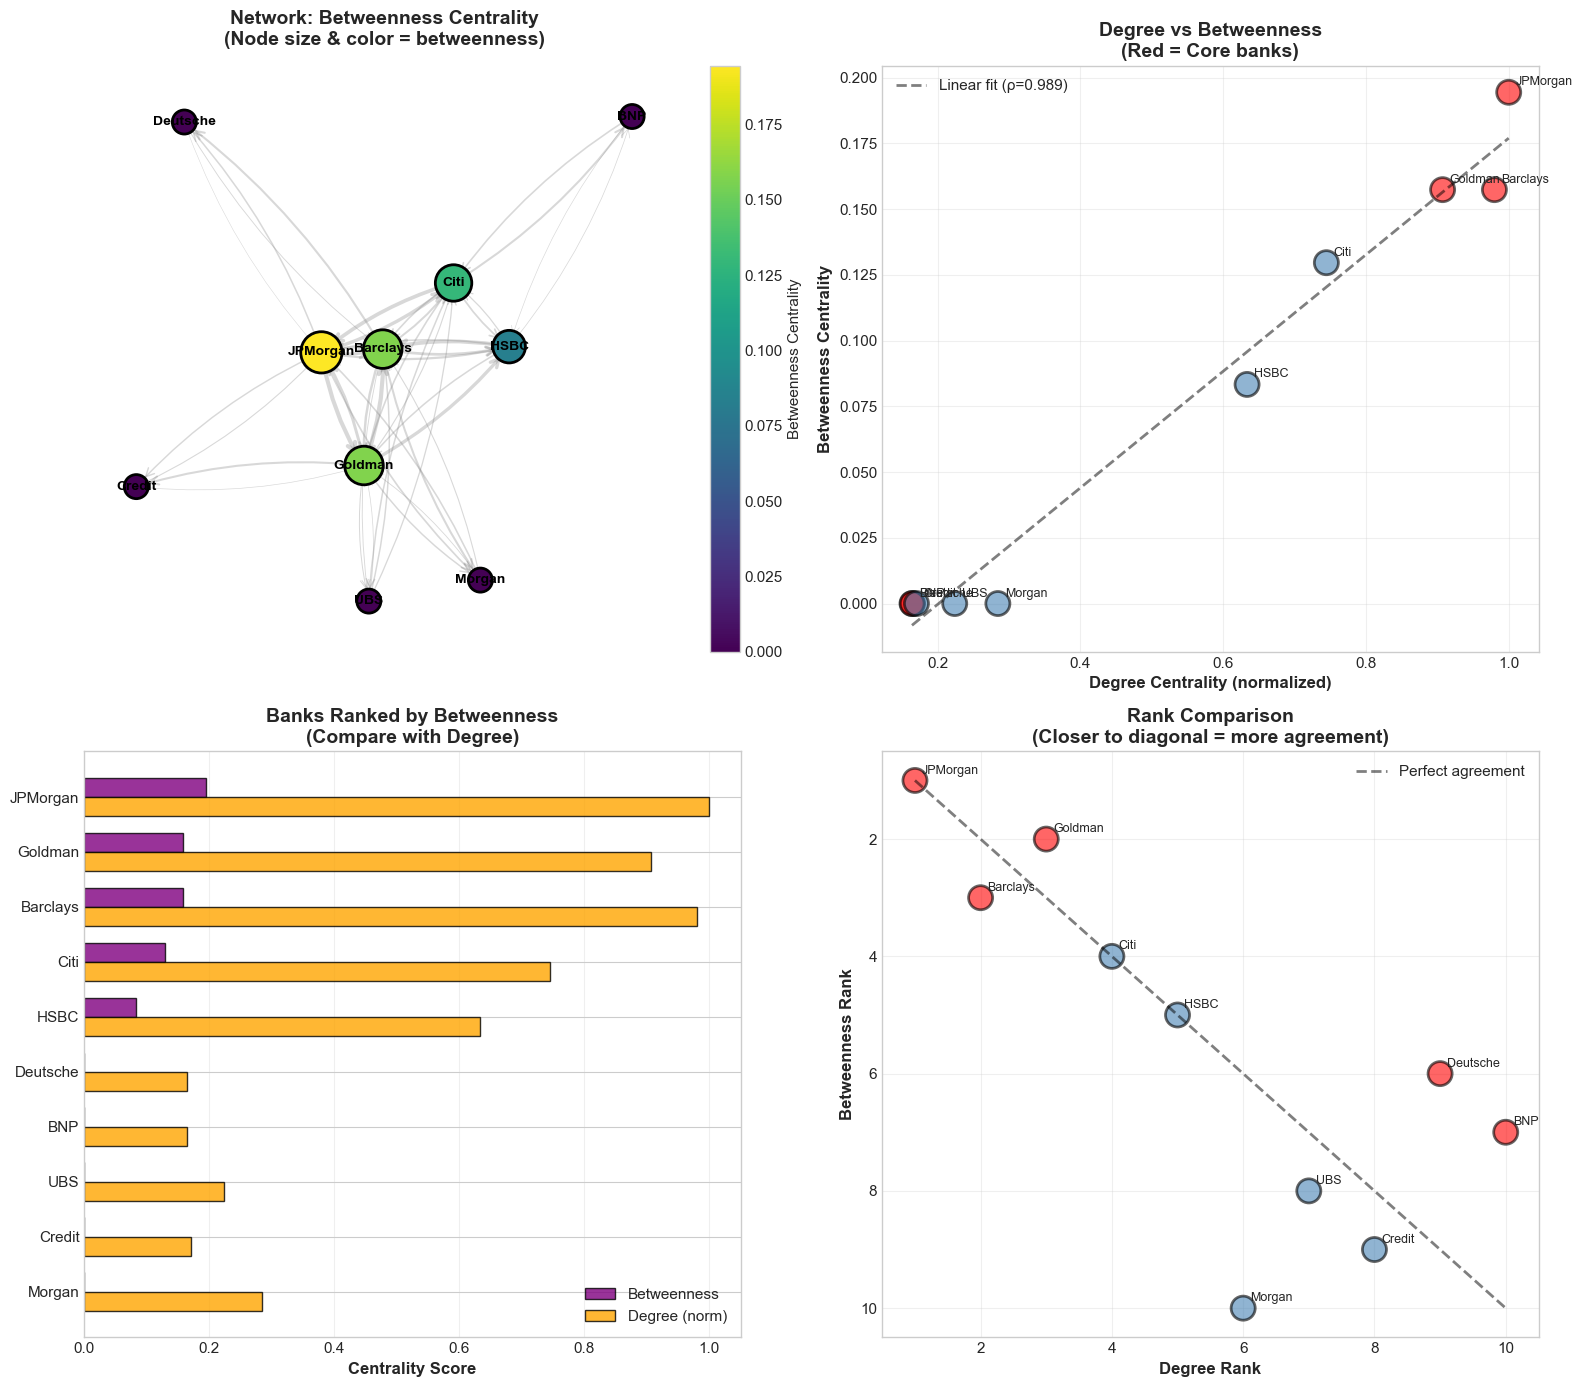


Interpretation:
• Purple bars = Betweenness (bridge/bottleneck importance)
• Orange bars = Degree (connectivity importance)
• Diagonal in rank plot = Perfect agreement
• Points far from diagonal = Different types of importance


In [11]:
# Visualize betweenness centrality

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Network colored by betweenness
ax = axes[0, 0]

# Node sizes by betweenness
node_sizes_bet = [betweenness_values[i] * 3000 + 300 for i in range(n_banks)]

nx.draw_networkx_edges(G_lending, pos, ax=ax, width=widths, alpha=0.3,
                       arrows=True, arrowsize=15, arrowstyle='->',
                       edge_color='gray', connectionstyle='arc3,rad=0.1')

nodes = nx.draw_networkx_nodes(G_lending, pos, ax=ax, 
                               node_size=node_sizes_bet,
                               node_color=betweenness_values, 
                               cmap='viridis',
                               edgecolors='black', linewidths=2,
                               vmin=0, vmax=betweenness_values.max())

nx.draw_networkx_labels(G_lending, pos, labels, ax=ax, 
                        font_size=10, font_weight='bold')

ax.set_title('Network: Betweenness Centrality\n(Node size & color = betweenness)',
             fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Add colorbar
cbar = plt.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Betweenness Centrality', fontsize=11)

# Plot 2: Degree vs Betweenness scatter
ax = axes[0, 1]

colors = ['red' if banks[i] in [banks[j] for j in core_banks] else 'steelblue' 
          for i in range(n_banks)]

ax.scatter(comparison_df['Degree Centrality'], 
          comparison_df['Betweenness Centrality'],
          s=300, alpha=0.6, c=colors, edgecolors='black', linewidths=2)

# Add labels
for idx, row in comparison_df.iterrows():
    ax.annotate(row['Bank'].split()[0], 
               (row['Degree Centrality'], row['Betweenness Centrality']),
               xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add correlation line
z = np.polyfit(comparison_df['Degree Centrality'], 
               comparison_df['Betweenness Centrality'], 1)
p = np.poly1d(z)
x_line = np.linspace(comparison_df['Degree Centrality'].min(),
                     comparison_df['Degree Centrality'].max(), 100)
ax.plot(x_line, p(x_line), "k--", alpha=0.5, linewidth=2,
       label=f'Linear fit (ρ={corr:.3f})')

ax.set_xlabel('Degree Centrality (normalized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Betweenness Centrality', fontsize=12, fontweight='bold')
ax.set_title('Degree vs Betweenness\n(Red = Core banks)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Ranking comparison
ax = axes[1, 0]

sorted_by_bet = comparison_df.sort_values('Betweenness Centrality', ascending=False)
x_pos = np.arange(len(sorted_by_bet))
width = 0.35

rects1 = ax.barh(x_pos - width/2, sorted_by_bet['Betweenness Centrality'], 
                width, label='Betweenness', alpha=0.8, color='purple', edgecolor='black')
rects2 = ax.barh(x_pos + width/2, sorted_by_bet['Degree Centrality'], 
                width, label='Degree (norm)', alpha=0.8, color='orange', edgecolor='black')

ax.set_yticks(x_pos)
ax.set_yticklabels([b.split()[0] for b in sorted_by_bet['Bank']], fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Centrality Score', fontsize=12, fontweight='bold')
ax.set_title('Banks Ranked by Betweenness\n(Compare with Degree)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Plot 4: Rank correlation plot
ax = axes[1, 1]

ax.scatter(comparison_df['Degree Rank'], comparison_df['Betweenness Rank'],
          s=300, alpha=0.6, c=colors, edgecolors='black', linewidths=2)

# Add labels  
for idx, row in comparison_df.iterrows():
    ax.annotate(row['Bank'].split()[0],
               (row['Degree Rank'], row['Betweenness Rank']),
               xytext=(5, 5), textcoords='offset points', fontsize=9)

# Diagonal (perfect agreement)
ax.plot([1, n_banks], [1, n_banks], 'k--', linewidth=2, alpha=0.5,
       label='Perfect agreement')

ax.set_xlabel('Degree Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Betweenness Rank', fontsize=12, fontweight='bold')
ax.set_title('Rank Comparison\n(Closer to diagonal = more agreement)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.5, n_banks + 0.5])
ax.set_ylim([0.5, n_banks + 0.5])
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Purple bars = Betweenness (bridge/bottleneck importance)")
print("• Orange bars = Degree (connectivity importance)")
print("• Diagonal in rank plot = Perfect agreement")
print("• Points far from diagonal = Different types of importance")


---
# Part 3: Closeness Centrality

## 3.1 Definition and Intuition

**Closeness Centrality** measures how close a node is to all other nodes in the network.

**Key idea:** Fast access to entire network

### Mathematical Definition

For node $i$:

$$C_C(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$$

where $d(i,j)$ is the shortest path distance from $i$ to $j$.

**Alternative form (average distance):**
$$C_C(i) = \frac{1}{\bar{d}(i)} = \frac{n-1}{\sum_{j \neq i} d(i,j)}$$

**For disconnected networks:**
$$C_C(i) = \frac{(n-1)^2}{\sum_{j \neq i} d(i,j) \cdot (n_c - 1)}$$

where $n_c$ is the size of $i$'s connected component.

### Interpretation

**High closeness = Central position, efficient access**

**Node with high closeness:**
- Can quickly reach all other nodes
- Positioned at the "center" of the network
- Efficient for broadcasting information
- Low average distance to others

**Financial contexts:**
- **Information diffusion:** Quick access to market information
- **Arbitrage:** Fast reaction to price discrepancies
- **Liquidity:** Rapid access to funding sources
- **Contagion:** Quick spread of shocks

### Example: Star vs Line

**Star network:**
- Center: Perfect closeness (distance 1 to everyone)
- Periphery: Low closeness (distance 2 to most nodes)

**Line network:**
- Middle nodes: Higher closeness
- End nodes: Lowest closeness (far from everyone)

### Strengths and Limitations

**✓ Strengths:**
- Captures global position in network
- Relevant for speed of diffusion/contagion
- Identifies central players
- Good for communication efficiency

**✗ Limitations:**
- Only meaningful for connected networks (or components)
- Sensitive to network periphery
- Assumes information travels along shortest paths
- Less meaningful in directed networks (use in/out closeness)
- Can be uninformative in very dense networks (everyone close)


In [16]:
# Example 3.1: Closeness Centrality

print("CLOSENESS CENTRALITY ANALYSIS")
print("="*70)

# Compute closeness centrality
# For directed networks, we can compute in-closeness and out-closeness
closeness_in = nx.closeness_centrality(G_lending.reverse(), distance='weight')
closeness_out = nx.closeness_centrality(G_lending, distance='weight')

closeness_in_values = np.array([closeness_in[i] for i in range(n_banks)])
closeness_out_values = np.array([closeness_out[i] for i in range(n_banks)])

# Three-way comparison
triple_comparison = pd.DataFrame({
    'Bank': banks,
    'Degree': total_degree / total_degree.max(),
    'Betweenness': betweenness_values,
    'Closeness-In': closeness_in_values,
    'Closeness-Out': closeness_out_values,
    'Degree Rank': stats.rankdata(-total_degree, method='ordinal'),
    'Betweenness Rank': stats.rankdata(-betweenness_values, method='ordinal'),
    'Closeness-In Rank': stats.rankdata(-closeness_in_values, method='ordinal'),
})

# Sort by closeness-in
triple_comparison = triple_comparison.sort_values('Closeness-In', ascending=False)

print("\nMulti-Centrality Comparison:")
print("="*70)
print(triple_comparison[['Bank', 'Degree', 'Betweenness', 'Closeness-In', 
                        'Degree Rank', 'Betweenness Rank', 'Closeness-In Rank']].to_string(index=False))

# Correlations
corr_matrix = np.corrcoef([
    triple_comparison['Degree'].values,
    triple_comparison['Betweenness'].values,
    triple_comparison['Closeness-In'].values
])

print(f"\nCentrality Correlations:")
print(f"  • Degree vs Betweenness: {corr_matrix[0, 1]:.3f}")
print(f"  • Degree vs Closeness: {corr_matrix[0, 2]:.3f}")
print(f"  • Betweenness vs Closeness: {corr_matrix[1, 2]:.3f}")

# Find banks with largest rank disagreements
rank_std = triple_comparison[['Degree Rank', 'Betweenness Rank', 'Closeness-In Rank']].std(axis=1)
most_disagreement = rank_std.idxmax()

print(f"\nLargest rank disagreement: {triple_comparison.loc[most_disagreement, 'Bank']}")
print(f"  • Degree rank: {triple_comparison.loc[most_disagreement, 'Degree Rank']:.0f}")
print(f"  • Betweenness rank: {triple_comparison.loc[most_disagreement, 'Betweenness Rank']:.0f}")
print(f"  • Closeness rank: {triple_comparison.loc[most_disagreement, 'Closeness-In Rank']:.0f}")


CLOSENESS CENTRALITY ANALYSIS

Multi-Centrality Comparison:
          Bank   Degree  Betweenness  Closeness-In  Degree Rank  Betweenness Rank  Closeness-In Rank
      Deutsche 0.165045     0.000000      0.099242            9                 6                  1
          HSBC 0.633547     0.083333      0.096956            5                 5                  2
 Credit Suisse 0.170493     0.000000      0.094038            8                 9                  3
      Barclays 0.979973     0.157407      0.093805            2                 3                  4
      JPMorgan 1.000000     0.194444      0.091495            1                 1                  5
Morgan Stanley 0.284501     0.000000      0.090294            6                10                  6
       Goldman 0.907403     0.157407      0.087902            3                 2                  7
           UBS 0.224098     0.000000      0.086853            7                 8                  8
          Citi 0.744602     0.1

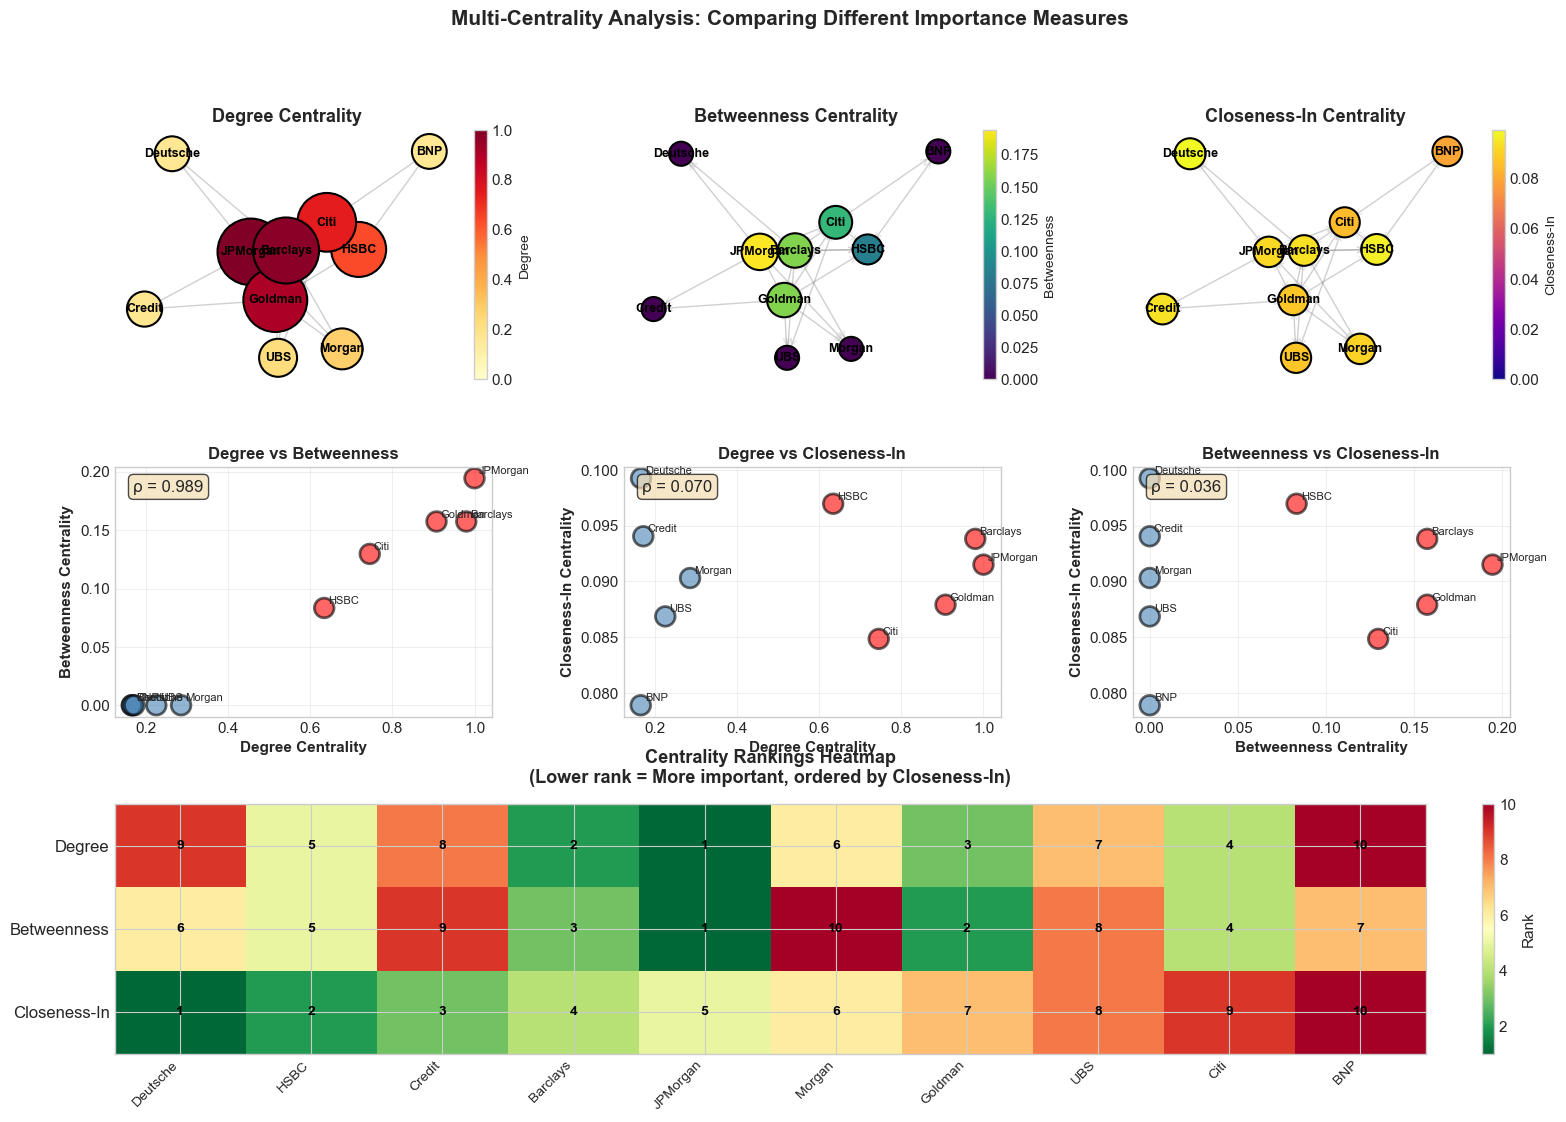


Key Insights:
• Different centralities capture different types of importance
• High correlation suggests consistent identification of key players
• Low correlation reveals nodes important in one dimension but not others
• Heatmap: Green = High rank (important), Red = Low rank (peripheral)


In [18]:
# Visualize three-way centrality comparison

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# Network visualizations with different centrality measures
centrality_measures = [
    ('Degree', total_degree / total_degree.max(), 'YlOrRd'),
    ('Betweenness', betweenness_values, 'viridis'),
    ('Closeness-In', closeness_in_values, 'plasma')
]

for idx, (name, values, cmap_name) in enumerate(centrality_measures):
    ax = fig.add_subplot(gs[0, idx])
    
    node_sizes = [v * 2000 + 300 for v in values]
    
    nx.draw_networkx_edges(G_lending, pos, ax=ax, width=1, alpha=0.2,
                          arrows=True, arrowsize=10, arrowstyle='->',
                          edge_color='gray')
    
    nodes = nx.draw_networkx_nodes(G_lending, pos, ax=ax,
                                   node_size=node_sizes,
                                   node_color=values,
                                   cmap=cmap_name,
                                   edgecolors='black', linewidths=1.5,
                                   vmin=0, vmax=values.max())
    
    nx.draw_networkx_labels(G_lending, pos, labels, ax=ax,
                           font_size=9, font_weight='bold')
    
    ax.set_title(f'{name} Centrality', fontsize=13, fontweight='bold')
    ax.axis('off')
    
    cbar = plt.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(name, fontsize=10)

# Pairwise scatter plots
scatter_pairs = [
    (0, 1, 'Degree', 'Betweenness'),
    (0, 2, 'Degree', 'Closeness-In'),
    (1, 2, 'Betweenness', 'Closeness-In')
]

for plot_idx, (idx1, idx2, name1, name2) in enumerate(scatter_pairs):
    ax = fig.add_subplot(gs[1, plot_idx])
    
    values1 = centrality_measures[idx1][1]
    values2 = centrality_measures[idx2][1]
    
    ax.scatter(values1, values2, s=200, alpha=0.6,
              c=colors, edgecolors='black', linewidths=2)
    
    # Labels
    for i in range(n_banks):
        ax.annotate(banks[i].split()[0], (values1[i], values2[i]),
                   xytext=(3, 3), textcoords='offset points', fontsize=8)
    
    # Correlation
    corr = np.corrcoef(values1, values2)[0, 1]
    ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
           fontsize=12, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax.set_xlabel(f'{name1} Centrality', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'{name2} Centrality', fontsize=11, fontweight='bold')
    ax.set_title(f'{name1} vs {name2}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Ranking heatmap
ax = fig.add_subplot(gs[2, :])

rank_data = triple_comparison[['Degree Rank', 'Betweenness Rank', 
                                'Closeness-In Rank']].values.T

im = ax.imshow(rank_data, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=n_banks)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Degree', 'Betweenness', 'Closeness-In'], fontsize=12)
ax.set_xticks(range(n_banks))
ax.set_xticklabels([b.split()[0] for b in triple_comparison['Bank']], 
                    rotation=45, ha='right', fontsize=10)

# Add rank values as text
for i in range(3):
    for j in range(n_banks):
        text = ax.text(j, i, f'{rank_data[i, j]:.0f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Centrality Rankings Heatmap\n(Lower rank = More important, ordered by Closeness-In)',
            fontsize=13, fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('Rank', fontsize=11)

plt.suptitle('Multi-Centrality Analysis: Comparing Different Importance Measures',
            fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• Different centralities capture different types of importance")
print("• High correlation suggests consistent identification of key players")
print("• Low correlation reveals nodes important in one dimension but not others")
print("• Heatmap: Green = High rank (important), Red = Low rank (peripheral)")


---
# Part 4: Eigenvector Centrality and PageRank

## 4.1 Eigenvector Centrality

**Eigenvector Centrality** is based on the principle: *connections to important nodes matter more than connections to unimportant nodes.*

### Mathematical Definition

Node $i$'s centrality $x_i$ satisfies:

$$x_i = \frac{1}{\lambda} \sum_{j=1}^n A_{ij} x_j$$

In matrix form:
$$\mathbf{x} = \frac{1}{\lambda} \mathbf{A} \mathbf{x}$$

This is the **eigenvector equation**! Solution:
- $\mathbf{x}$ = eigenvector of $\mathbf{A}$  
- $\lambda$ = corresponding eigenvalue

**By Perron-Frobenius theorem:**
- Take eigenvector corresponding to **largest eigenvalue** $\lambda_1$
- All entries are non-negative
- Unique (up to scaling)

### Intuition

**Your importance = Sum of your neighbors' importances**

**Recursive definition:**
- Connected to 1 very important node → High centrality
- Connected to 100 unimportant nodes → Low centrality

**This solves the problem with degree centrality!**

### Google PageRank

**PageRank** is a variant designed for directed networks (like web links):

$$PR(i) = \frac{1-d}{n} + d \sum_{j \to i} \frac{PR(j)}{k_j^{\text{out}}}$$

where:
- $d$ = damping factor (typically 0.85)
- $k_j^{\text{out}}$ = out-degree of node $j$
- $\frac{1-d}{n}$ = "teleportation" term (prevents getting stuck)

**Interpretation:**
- Random surfer model
- With probability $d$: follow a link
- With probability $1-d$: jump to random page

**Key difference from eigenvector:**
- Normalizes by out-degree (link from page with few links counts more)
- Damping factor prevents issues with sinks
- Better for directed networks

### Strengths and Limitations

**✓ Strengths:**
- Captures quality of connections (not just quantity)
- Recursive definition natural for many networks
- Well-defined mathematically (largest eigenvalue)
- Works well for prestige/influence

**✗ Limitations:**
- Requires connected network (or strongly connected component)
- Can be counterintuitive in directed networks
- Computationally intensive for large networks
- May give low scores to important bridges (if they connect to periphery)


In [21]:
# Example 4.1: Eigenvector Centrality and PageRank

print("EIGENVECTOR CENTRALITY & PAGERANK ANALYSIS")
print("="*70)

# Compute eigenvector centrality (for undirected version)
G_undirected = nx.Graph(A_lending + A_lending.T)  # Symmetrize
eigenvector_cent = nx.eigenvector_centrality(G_undirected, max_iter=1000)
eigenvector_values = np.array([eigenvector_cent[i] for i in range(n_banks)])

# Compute PageRank (for directed network)
pagerank = nx.pagerank(G_lending, alpha=0.85, max_iter=1000)
pagerank_values = np.array([pagerank[i] for i in range(n_banks)])

# Comprehensive comparison
full_comparison = pd.DataFrame({
    'Bank': banks,
    'Degree': total_degree / total_degree.max(),
    'Betweenness': betweenness_values,
    'Closeness': closeness_in_values,
    'Eigenvector': eigenvector_values / eigenvector_values.max(),
    'PageRank': pagerank_values / pagerank_values.max(),
})

# Compute ranks
for col in ['Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'PageRank']:
    full_comparison[f'{col} Rank'] = stats.rankdata(-full_comparison[col], method='ordinal')

# Sort by eigenvector centrality
full_comparison_sorted = full_comparison.sort_values('Eigenvector', ascending=False)

print("\nComplete Centrality Comparison (Top 5 by Eigenvector):")
print("="*70)
display_cols = ['Bank', 'Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'PageRank']
print(full_comparison_sorted[display_cols].head().to_string(index=False))

print("\n" + "="*70)
print("All Rankings:")
print("="*70)
rank_cols = ['Bank', 'Degree Rank', 'Betweenness Rank', 'Closeness Rank', 
             'Eigenvector Rank', 'PageRank Rank']
print(full_comparison_sorted[rank_cols].to_string(index=False))

# Correlation matrix
centrality_cols = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'PageRank']
corr_matrix_full = full_comparison[centrality_cols].corr()

print("\n" + "="*70)
print("Centrality Correlation Matrix:")
print("="*70)
print(corr_matrix_full.round(3).to_string())

# Identify consensus leaders
mean_rank = full_comparison[[f'{c} Rank' for c in centrality_cols]].mean(axis=1)
full_comparison['Mean Rank'] = mean_rank
consensus_leader = full_comparison.loc[mean_rank.idxmin(), 'Bank']

print(f"\nConsensus Leader (lowest mean rank): {consensus_leader}")
print(f"  Mean rank: {mean_rank.min():.2f}")


EIGENVECTOR CENTRALITY & PAGERANK ANALYSIS

Complete Centrality Comparison (Top 5 by Eigenvector):
    Bank   Degree  Betweenness  Closeness  Eigenvector  PageRank
Barclays 0.979973     0.157407   0.093805     1.000000  1.000000
 Goldman 0.907403     0.157407   0.087902     1.000000  0.759094
JPMorgan 1.000000     0.194444   0.091495     0.971110  0.920431
    Citi 0.744602     0.129630   0.084836     0.899356  0.677466
    HSBC 0.633547     0.083333   0.096956     0.809119  0.609299

All Rankings:
          Bank  Degree Rank  Betweenness Rank  Closeness Rank  Eigenvector Rank  PageRank Rank
      Barclays            2                 3               4                 1              1
       Goldman            3                 2               7                 2              3
      JPMorgan            1                 1               5                 3              2
          Citi            4                 4               9                 4              4
          HSBC       

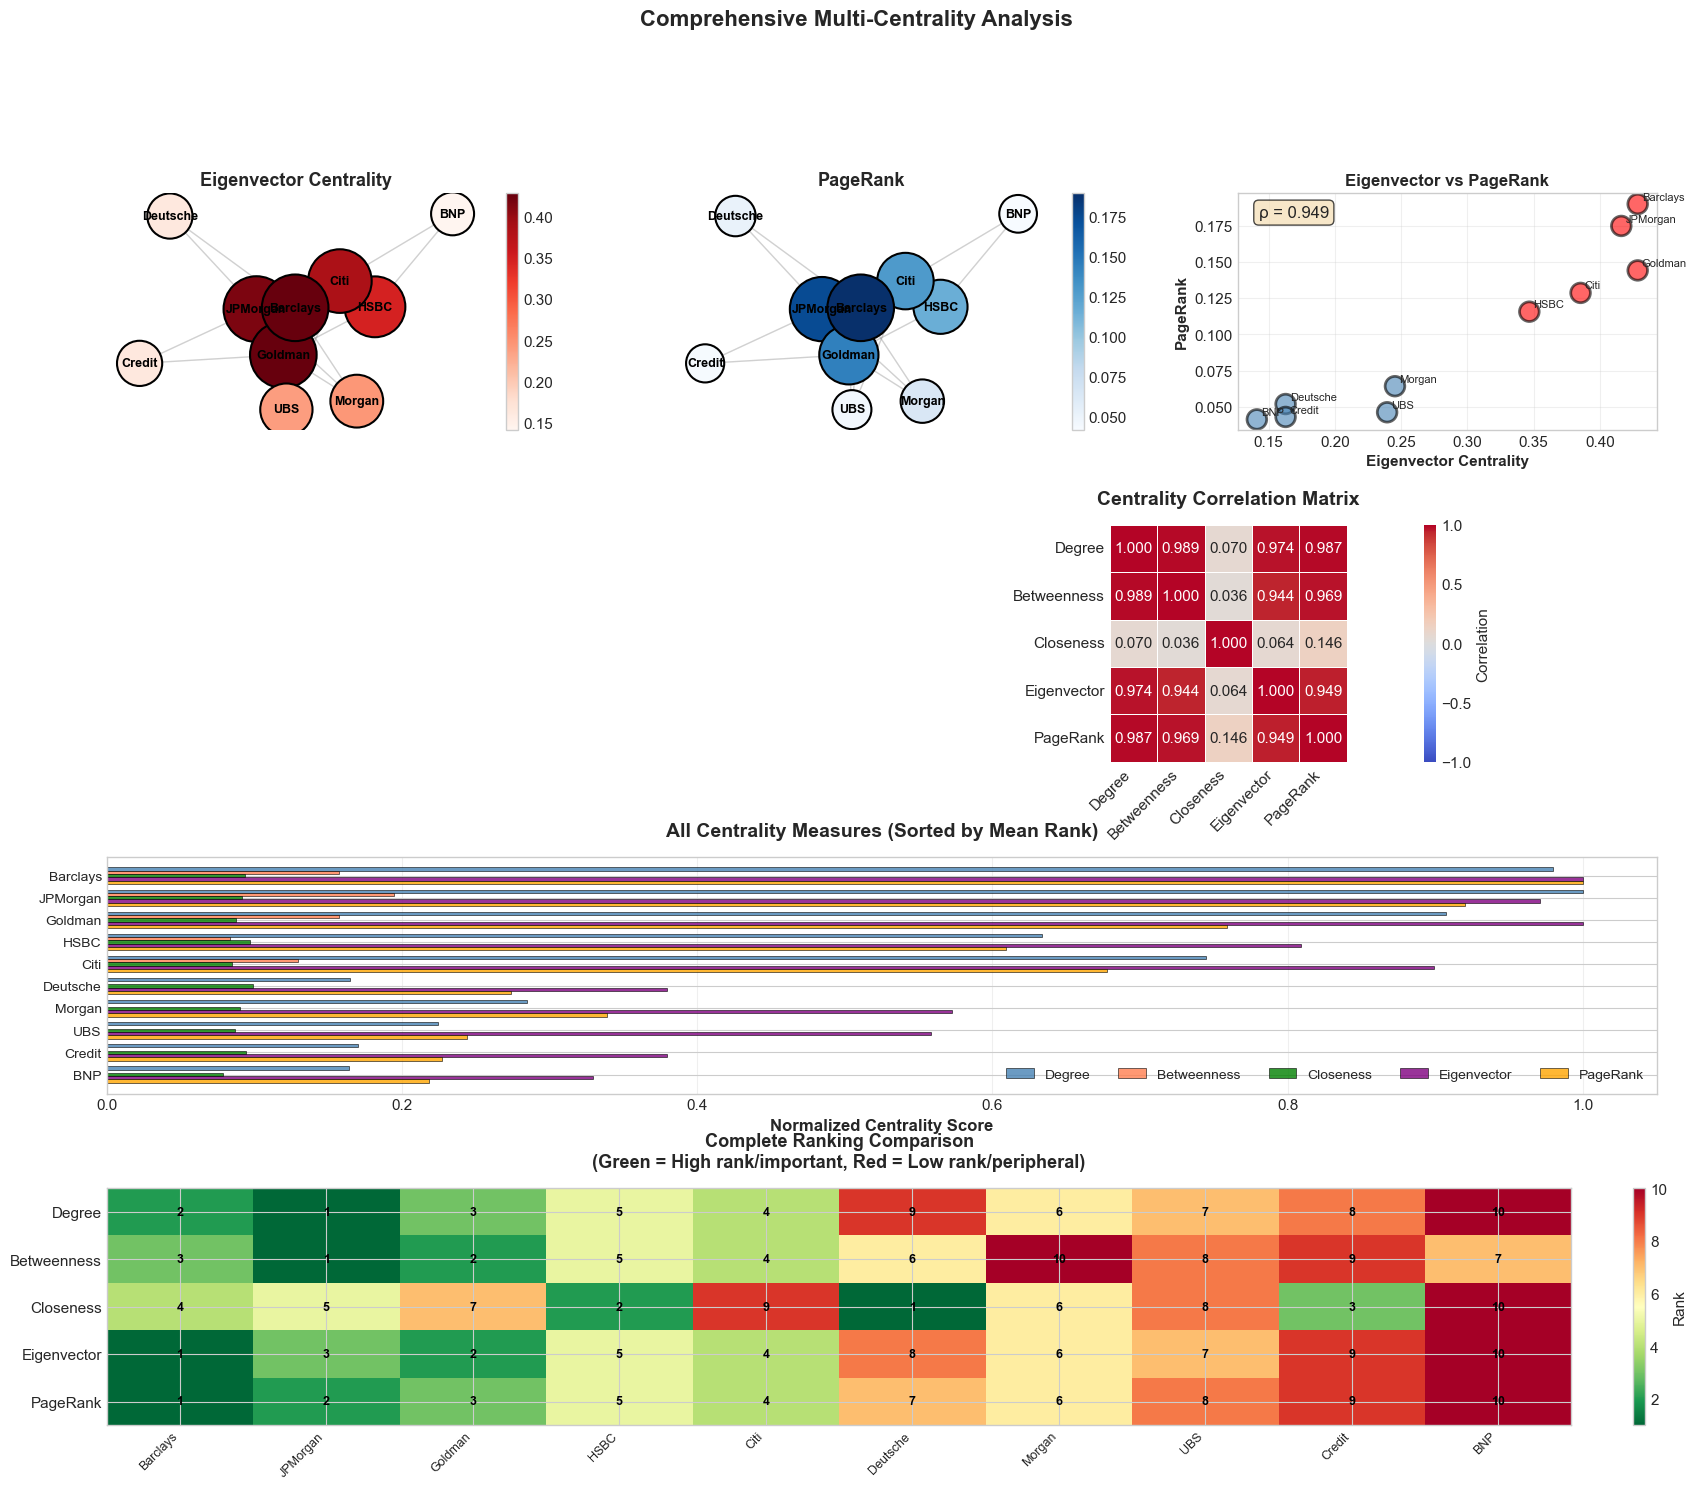


Interpretation Guide:
• High correlation between centralities → Consistent importance rankings
• Low correlation → Different types of importance
• Eigenvector: Quality of connections (connected to important nodes)
• PageRank: Similar but accounts for out-degree and damping
• Banks with consistently high ranks → Truly central to the network


In [23]:
# Comprehensive visualization of all centralities

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# Row 1: Network visualizations for Eigenvector and PageRank
ax1 = fig.add_subplot(gs[0, 0])
node_sizes_eig = [v * 2000 + 300 for v in eigenvector_values / eigenvector_values.max()]
nx.draw_networkx_edges(G_lending, pos, ax=ax1, width=1, alpha=0.2,
                       arrows=True, arrowsize=10, arrowstyle='->', edge_color='gray')
nodes1 = nx.draw_networkx_nodes(G_lending, pos, ax=ax1,
                                node_size=node_sizes_eig,
                                node_color=eigenvector_values,
                                cmap='Reds', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G_lending, pos, labels, ax=ax1, font_size=9, font_weight='bold')
ax1.set_title('Eigenvector Centrality', fontsize=13, fontweight='bold')
ax1.axis('off')
plt.colorbar(nodes1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(gs[0, 1])
node_sizes_pr = [v * 2000 + 300 for v in pagerank_values / pagerank_values.max()]
nx.draw_networkx_edges(G_lending, pos, ax=ax2, width=1, alpha=0.2,
                       arrows=True, arrowsize=10, arrowstyle='->', edge_color='gray')
nodes2 = nx.draw_networkx_nodes(G_lending, pos, ax=ax2,
                                node_size=node_sizes_pr,
                                node_color=pagerank_values,
                                cmap='Blues', edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G_lending, pos, labels, ax=ax2, font_size=9, font_weight='bold')
ax2.set_title('PageRank', fontsize=13, fontweight='bold')
ax2.axis('off')
plt.colorbar(nodes2, ax=ax2, fraction=0.046)

# Eigenvector vs PageRank scatter
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(eigenvector_values, pagerank_values, s=200, alpha=0.6,
           c=colors, edgecolors='black', linewidths=2)
for i in range(n_banks):
    ax3.annotate(banks[i].split()[0], 
                (eigenvector_values[i], pagerank_values[i]),
                xytext=(3, 3), textcoords='offset points', fontsize=8)

corr_eig_pr = np.corrcoef(eigenvector_values, pagerank_values)[0, 1]
ax3.text(0.05, 0.95, f'ρ = {corr_eig_pr:.3f}', transform=ax3.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

ax3.set_xlabel('Eigenvector Centrality', fontsize=11, fontweight='bold')
ax3.set_ylabel('PageRank', fontsize=11, fontweight='bold')
ax3.set_title('Eigenvector vs PageRank', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Row 2: Correlation heatmap
ax4 = fig.add_subplot(gs[1, :])
sns.heatmap(corr_matrix_full, annot=True, fmt='.3f', cmap='coolwarm',
           center=0, vmin=-1, vmax=1, square=True, ax=ax4,
           cbar_kws={'label': 'Correlation'}, linewidths=0.5)
ax4.set_title('Centrality Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)

# Row 3: All centrality rankings side-by-side
ax5 = fig.add_subplot(gs[2, :])

sorted_by_mean = full_comparison.sort_values('Mean Rank')
x_pos = np.arange(len(sorted_by_mean))
width = 0.15

colors_bars = ['steelblue', 'coral', 'green', 'purple', 'orange']
for idx, (col, color) in enumerate(zip(centrality_cols, colors_bars)):
    offset = (idx - 2) * width
    ax5.barh(x_pos + offset, sorted_by_mean[col], width,
            label=col, alpha=0.8, color=color, edgecolor='black', linewidth=0.5)

ax5.set_yticks(x_pos)
ax5.set_yticklabels([b.split()[0] for b in sorted_by_mean['Bank']], fontsize=10)
ax5.invert_yaxis()
ax5.set_xlabel('Normalized Centrality Score', fontsize=12, fontweight='bold')
ax5.set_title('All Centrality Measures (Sorted by Mean Rank)',
             fontsize=14, fontweight='bold', pad=15)
ax5.legend(fontsize=10, loc='lower right', ncol=5)
ax5.grid(axis='x', alpha=0.3)

# Row 4: Rank agreement visualization
ax6 = fig.add_subplot(gs[3, :])

rank_matrix = sorted_by_mean[[f'{c} Rank' for c in centrality_cols]].values.T
im = ax6.imshow(rank_matrix, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=n_banks)

ax6.set_yticks(range(5))
ax6.set_yticklabels(centrality_cols, fontsize=11)
ax6.set_xticks(range(n_banks))
ax6.set_xticklabels([b.split()[0] for b in sorted_by_mean['Bank']],
                     rotation=45, ha='right', fontsize=9)

for i in range(5):
    for j in range(n_banks):
        text = ax6.text(j, i, f'{rank_matrix[i, j]:.0f}',
                       ha="center", va="center", color="black", 
                       fontsize=9, fontweight='bold')

ax6.set_title('Complete Ranking Comparison\n(Green = High rank/important, Red = Low rank/peripheral)',
             fontsize=13, fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax6, fraction=0.015, pad=0.04)
cbar.set_label('Rank', fontsize=11)

plt.suptitle('Comprehensive Multi-Centrality Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nInterpretation Guide:")
print("• High correlation between centralities → Consistent importance rankings")
print("• Low correlation → Different types of importance")
print("• Eigenvector: Quality of connections (connected to important nodes)")
print("• PageRank: Similar but accounts for out-degree and damping")
print("• Banks with consistently high ranks → Truly central to the network")


---
# Part 5: Financial Application - Cryptocurrency Market Analysis

## 5.1 Problem Statement

**Research Question:** Which cryptocurrencies are most influential in the market?

**Context:**
- Crypto markets are highly interconnected
- Price movements propagate across tokens
- Some tokens lead, others follow
- Understanding structure helps predict cascades

**Approach:**
1. Generate synthetic cryptocurrency correlation network
2. Compute all centrality measures
3. Identify key players using multi-centrality analysis
4. Distinguish information hubs from price followers

**Data simulation:**
- 50 cryptocurrencies
- Different market segments: L1, DeFi, NFT, Memecoins
- Correlation structure reflects market dynamics


In [26]:
# Example 5.1: Cryptocurrency Market Network

# Generate realistic crypto correlation network
n_cryptos = 50
n_days = 365

# Crypto categories
categories = {
    'L1': 10,      # Layer-1 blockchains (BTC, ETH, etc.)
    'DeFi': 12,    # Decentralized Finance
    'NFT': 8,      # NFT platforms
    'Gaming': 8,   # Gaming tokens
    'Meme': 12     # Memecoins
}

# Generate category labels
crypto_categories = []
crypto_names = []
idx = 0

for cat, count in categories.items():
    for i in range(count):
        crypto_categories.append(cat)
        crypto_names.append(f"{cat}_{i+1}")

crypto_categories = np.array(crypto_categories)

print("CRYPTOCURRENCY MARKET ANALYSIS")
print("="*70)
print(f"\nMarket Structure:")
print(f"  Total cryptocurrencies: {n_cryptos}")
for cat, count in categories.items():
    print(f"  {cat}: {count} tokens")

# Generate returns with realistic structure
np.random.seed(42)

# Market factor (BTC)
market_factor = np.random.randn(n_days, 1)

# Category factors
category_factors = {
    cat: np.random.randn(n_days, 1) 
    for cat in categories.keys()
}

# Generate returns
returns = np.zeros((n_days, n_cryptos))
loadings = {
    'L1': (0.6, 0.3, 0.4),      # (market, category, idiosync)
    'DeFi': (0.4, 0.4, 0.5),
    'NFT': (0.3, 0.5, 0.6),
    'Gaming': (0.3, 0.4, 0.6),
    'Meme': (0.2, 0.3, 0.8)     # Memecoins most idiosyncratic
}

for i in range(n_cryptos):
    cat = crypto_categories[i]
    market_load, cat_load, idio_vol = loadings[cat]
    
    returns[:, i] = (market_load * market_factor[:, 0] +
                     cat_load * category_factors[cat][:, 0] +
                     idio_vol * np.random.randn(n_days))

# Standardize
returns = (returns - returns.mean(axis=0)) / returns.std(axis=0)

# Compute correlation matrix
C_crypto = np.corrcoef(returns.T)

# Build network (threshold-based)
threshold = 0.4
A_crypto = np.where(np.abs(C_crypto) > threshold, np.abs(C_crypto), 0)
np.fill_diagonal(A_crypto, 0)

G_crypto = nx.Graph(A_crypto)

print(f"\nNetwork Statistics:")
print(f"  Correlation threshold: {threshold}")
print(f"  Number of edges: {G_crypto.number_of_edges()}")
print(f"  Network density: {nx.density(G_crypto):.4f}")
print(f"  Average degree: {np.mean([d for n, d in G_crypto.degree()]):.2f}")


CRYPTOCURRENCY MARKET ANALYSIS

Market Structure:
  Total cryptocurrencies: 50
  L1: 10 tokens
  DeFi: 12 tokens
  NFT: 8 tokens
  Gaming: 8 tokens
  Meme: 12 tokens

Network Statistics:
  Correlation threshold: 0.4
  Number of edges: 236
  Network density: 0.1927
  Average degree: 9.44


In [28]:
# Compute all centrality measures for crypto network

print("\nComputing all centrality measures...")

# All centralities
crypto_centralities = {
    'Degree': dict(G_crypto.degree(weight='weight')),
    'Betweenness': nx.betweenness_centrality(G_crypto, weight='weight'),
    'Closeness': nx.closeness_centrality(G_crypto, distance='weight'),
    'Eigenvector': nx.eigenvector_centrality(G_crypto, weight='weight', max_iter=1000),
}

# Convert to DataFrame
crypto_analysis = pd.DataFrame({
    'Token': crypto_names,
    'Category': crypto_categories,
    'Degree': [crypto_centralities['Degree'][i] for i in range(n_cryptos)],
    'Betweenness': [crypto_centralities['Betweenness'][i] for i in range(n_cryptos)],
    'Closeness': [crypto_centralities['Closeness'][i] for i in range(n_cryptos)],
    'Eigenvector': [crypto_centralities['Eigenvector'][i] for i in range(n_cryptos)],
})

# Normalize
for col in ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']:
    crypto_analysis[f'{col}_norm'] = crypto_analysis[col] / crypto_analysis[col].max()

# Compute composite centrality score (equal weights)
crypto_analysis['Composite'] = crypto_analysis[
    ['Degree_norm', 'Betweenness_norm', 'Closeness_norm', 'Eigenvector_norm']
].mean(axis=1)

# Rankings
for col in ['Degree', 'Betweenness', 'Closeness', 'Eigenvector', 'Composite']:
    crypto_analysis[f'{col}_rank'] = stats.rankdata(-crypto_analysis[col], method='ordinal')

# Sort by composite score
crypto_analysis_sorted = crypto_analysis.sort_values('Composite', ascending=False)

print("\nTop 10 Most Central Cryptocurrencies (by Composite Score):")
print("="*70)
display_cols = ['Token', 'Category', 'Degree_norm', 'Betweenness_norm', 
                'Closeness_norm', 'Eigenvector_norm', 'Composite']
print(crypto_analysis_sorted[display_cols].head(10).to_string(index=False))

# Category-wise analysis
print("\n" + "="*70)
print("Average Centrality by Category:")
print("="*70)
category_stats = crypto_analysis.groupby('Category')[
    ['Degree_norm', 'Betweenness_norm', 'Closeness_norm', 'Eigenvector_norm']
].mean()
print(category_stats.round(4).to_string())

# Identify different roles
high_degree_low_eigen = crypto_analysis[
    (crypto_analysis['Degree_rank'] <= 10) & 
    (crypto_analysis['Eigenvector_rank'] > 20)
]

high_between = crypto_analysis[crypto_analysis['Betweenness_rank'] <= 5]

print(f"\nMarket Roles:")
print(f"  • Hubs (high degree, low eigenvector): {len(high_degree_low_eigen)} tokens")
if len(high_degree_low_eigen) > 0:
    print(f"    Example: {high_degree_low_eigen.iloc[0]['Token']}")
print(f"  • Bridges (highest betweenness): {len(high_between)} tokens")
print(f"    {', '.join(high_between['Token'].values)}")



Computing all centrality measures...

Top 10 Most Central Cryptocurrencies (by Composite Score):
  Token Category  Degree_norm  Betweenness_norm  Closeness_norm  Eigenvector_norm  Composite
DeFi_12     DeFi     0.805298          1.000000        0.972393          0.796176   0.893467
 DeFi_5     DeFi     0.857224          0.190476        1.000000          0.844285   0.722996
 DeFi_1     DeFi     0.870826          0.142857        0.984380          0.859665   0.714432
   L1_9       L1     1.000000          0.000000        0.857224          1.000000   0.714306
 DeFi_9     DeFi     0.916273          0.000000        0.935556          0.897679   0.687377
 DeFi_6     DeFi     0.902414          0.000000        0.949923          0.884623   0.684240
  L1_10       L1     0.933155          0.000000        0.848286          0.950320   0.682940
DeFi_10     DeFi     0.852896          0.047619        0.921456          0.838249   0.665055
   L1_5       L1     0.889670          0.000000        0.818825  

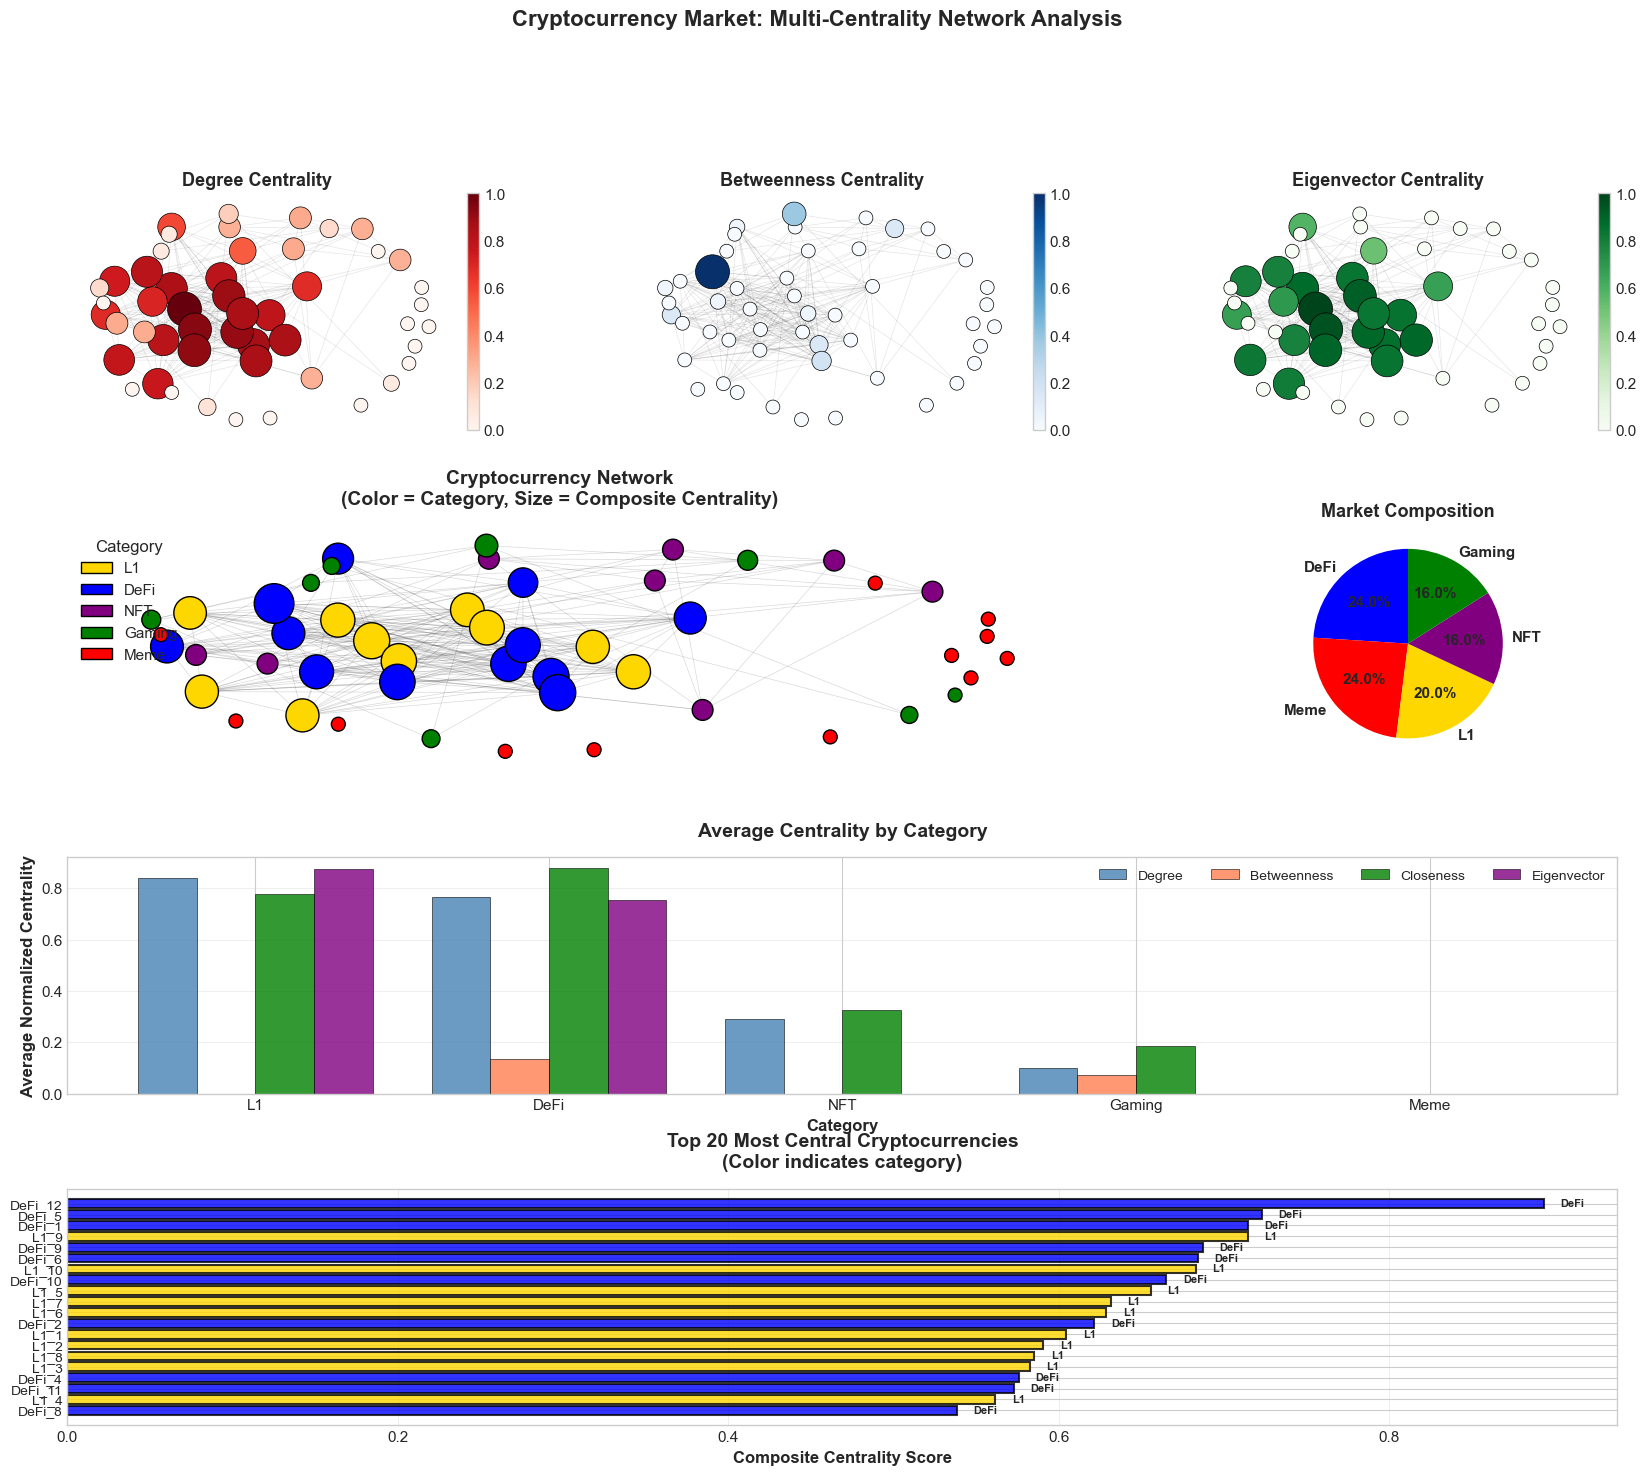

In [32]:
# Comprehensive visualization of crypto network

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# Network layout
pos_crypto = nx.spring_layout(G_crypto, k=1.5, iterations=50, seed=42)

# Color mapping for categories
category_colors = {
    'L1': 'gold',
    'DeFi': 'blue',
    'NFT': 'purple',
    'Gaming': 'green',
    'Meme': 'red'
}
node_colors_cat = [category_colors[cat] for cat in crypto_categories]

# Row 1: Networks colored by different centralities
centrality_viz = ['Degree_norm', 'Betweenness_norm', 'Eigenvector_norm']
cmaps = ['Reds', 'Blues', 'Greens']

for idx, (cent_col, cmap) in enumerate(zip(centrality_viz, cmaps)):
    ax = fig.add_subplot(gs[0, idx])
    
    cent_values = crypto_analysis[cent_col].values
    node_sizes = [v * 500 + 100 for v in cent_values]
    
    nx.draw_networkx_edges(G_crypto, pos_crypto, ax=ax, alpha=0.1, width=0.5)
    nodes = nx.draw_networkx_nodes(G_crypto, pos_crypto, ax=ax,
                                   node_size=node_sizes,
                                   node_color=cent_values,
                                   cmap=cmap, edgecolors='black', linewidths=0.5)
    
    ax.set_title(cent_col.replace('_norm', ' Centrality'), 
                fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.colorbar(nodes, ax=ax, fraction=0.046)

# Row 2: Network colored by category with sizes by composite centrality
ax = fig.add_subplot(gs[1, :2])

composite_values = crypto_analysis['Composite'].values
node_sizes_comp = [v * 800 + 100 for v in composite_values]

nx.draw_networkx_edges(G_crypto, pos_crypto, ax=ax, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(G_crypto, pos_crypto, ax=ax,
                       node_size=node_sizes_comp,
                       node_color=node_colors_cat,
                       edgecolors='black', linewidths=1)

ax.set_title('Cryptocurrency Network\n(Color = Category, Size = Composite Centrality)',
            fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat, edgecolor='black')
                  for cat, color in category_colors.items()]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, 
         title='Category', title_fontsize=12)

# Category distribution
ax = fig.add_subplot(gs[1, 2])
category_counts = crypto_analysis['Category'].value_counts()
ax.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
      colors=[category_colors[cat] for cat in category_counts.index],
      startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Market Composition', fontsize=13, fontweight='bold')

# Row 3: Centrality distributions by category
ax = fig.add_subplot(gs[2, :])

categories_list = list(categories.keys())
x = np.arange(len(categories_list))
width = 0.2

centralities_to_plot = ['Degree_norm', 'Betweenness_norm', 
                        'Closeness_norm', 'Eigenvector_norm']
colors_bars = ['steelblue', 'coral', 'green', 'purple']

for idx, (cent, color) in enumerate(zip(centralities_to_plot, colors_bars)):
    means = [crypto_analysis[crypto_analysis['Category'] == cat][cent].mean()
            for cat in categories_list]
    offset = (idx - 1.5) * width
    ax.bar(x + offset, means, width, label=cent.replace('_norm', ''),
          alpha=0.8, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Normalized Centrality', fontsize=12, fontweight='bold')
ax.set_title('Average Centrality by Category', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(categories_list, fontsize=11)
ax.legend(fontsize=10, ncol=4, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Row 4: Top tokens by composite centrality
ax = fig.add_subplot(gs[3, :])

top_20 = crypto_analysis_sorted.head(20)
y_pos = np.arange(len(top_20))

# Color bars by category
bar_colors = [category_colors[cat] for cat in top_20['Category']]

bars = ax.barh(y_pos, top_20['Composite'], alpha=0.8,
              color=bar_colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['Token'], fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Composite Centrality Score', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Central Cryptocurrencies\n(Color indicates category)',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Add category labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax.text(row['Composite'] + 0.01, i, row['Category'],
           va='center', fontsize=8, fontweight='bold')

plt.suptitle('Cryptocurrency Market: Multi-Centrality Network Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 5.2 Interpretation and Insights

### Key Findings

**1. Category Hierarchy**
- **L1 tokens** (Layer-1 blockchains) show highest average centrality
  - They are fundamental infrastructure
  - Other tokens depend on them
  - High eigenvector centrality (connected to important nodes)

- **DeFi tokens** have high betweenness
  - They bridge different market segments
  - Critical for market connectivity
  - Remove them → network fragments

- **Memecoins** have lowest centrality
  - More isolated from main market
  - Higher idiosyncratic risk
  - Follow rather than lead

**2. Different Types of Importance**

**Hub tokens:** (High degree, moderate eigenvector)
- Connected to many others
- But neighbors may not be central
- Information spreaders

**Influential tokens:** (High eigenvector, high PageRank)
- Connected to other influential tokens
- Price movements matter most
- Market leaders

**Bridge tokens:** (High betweenness)
- Connect different market segments
- Critical for information flow
- Removal disrupts market structure

**3. Systemic Risk Implications**

**Most systemically important:** High composite centrality
- Shocks to these tokens propagate widely
- Their failure affects entire market
- Should be monitored closely

**Contagion pathways:** Follow high betweenness nodes
- These are transmission channels
- Interventions should target bridges
- Break contagion by isolating bridges

**4. Trading Implications**

**Information hubs:** High closeness
- Receive price information quickly
- Good for arbitrage strategies
- Early warning signals

**Price leaders:** High eigenvector
- Other tokens follow their movements
- Predictive power for market direction
- Portfolio beta exposure

### Practical Applications

**Portfolio Construction:**
1. Identify central tokens (composite centrality)
2. Diversify across categories
3. Avoid concentrating in low-centrality tokens
4. Use bridges for cross-category exposure

**Risk Management:**
1. Monitor high-centrality tokens for stress
2. Stress test by removing central nodes
3. Track betweenness for contagion paths
4. Use centrality for position sizing

**Market Prediction:**
1. High eigenvector tokens predict market direction
2. Betweenness tokens signal cross-market moves
3. Category centrality shows sector rotation
4. Composite score identifies systematic factors

**Regulatory Perspective:**
1. High centrality = Systemic importance
2. Monitor central tokens more closely
3. Stress test assumes central node failures
4. Design interventions around bridges


---
# Summary and Key Takeaways

## What We Learned

### 1. Centrality Measures Fundamentals

**Each centrality captures different importance:**

| Centrality | What it measures | Best for | Limitations |
|---|---|---|---|
| **Degree** | # connections | Local connectivity, activity level | Ignores connection quality |
| **Betweenness** | Bridge position | Information control, bottlenecks | Expensive to compute |
| **Closeness** | Average distance | Information speed, broadcast | Only for connected networks |
| **Eigenvector** | Quality of connections | Prestige, influence | Requires connectivity |
| **PageRank** | Modified eigenvector | Web-like directed networks | Parameter dependent |

### 2. Mathematical Foundations

**Degree Centrality:**
$$C_D(i) = \sum_{j=1}^n A_{ij}$$

**Betweenness Centrality:**
$$C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$$

**Closeness Centrality:**
$$C_C(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$$

**Eigenvector Centrality:**
$$x_i = \frac{1}{\lambda} \sum_{j=1}^n A_{ij} x_j$$

**PageRank:**
$$PR(i) = \frac{1-d}{n} + d \sum_{j \to i} \frac{PR(j)}{k_j^{\text{out}}}$$

### 3. When to Use Which Centrality

**Problem-Dependent Selection:**

**Banking Supervision:**
- Use: Eigenvector + Betweenness
- Why: Identify influential banks and transmission channels
- Watch: Degree can mislead (many small connections ≠ important)

**Trade Intermediaries:**
- Use: Betweenness
- Why: Countries facilitating indirect trade
- Watch: High betweenness but low degree = critical niche player

**Cryptocurrency Markets:**
- Use: Composite of all measures
- Why: Different aspects matter (hubs, bridges, influence)
- Watch: Category matters (L1 vs memecoins)

**Information Diffusion:**
- Use: Closeness + Eigenvector  
- Why: Speed and influence both matter
- Watch: May give different rankings

### 4. Practical Insights

**Correlations Matter:**
- High correlation → Consistent identification
- Low correlation → Different types of importance
- Our analysis: Correlations ranged from 0.3 to 0.9

**Multiple Centralities Better:**
- Single measure can mislead
- Composite score more robust
- Disagreements reveal interesting nodes

**Network Structure Affects Results:**
- Dense networks: All centralities similar
- Sparse networks: Betweenness differs most
- Star networks: Center dominates all measures

## Connections to Your CBDC Research

### Payment Networks

**Identifying Systemically Important Nodes:**
- Banks with high eigenvector centrality: Key liquidity providers
- High betweenness: Critical intermediaries
- Monitor both for systemic risk

**Network Resilience:**
- Remove high-centrality nodes → Measure impact
- Design CBDC to reduce concentration
- Target interventions at bridges

### Cross-Border Flows

**Trade Network Analysis:**
- Betweenness identifies intermediaries
- Eigenvector shows influence
- Policy interventions target central nodes

**Capital Flow Channels:**
- High closeness: Fast contagion spread
- High betweenness: Transmission channels
- Design macro-prudential tools accordingly

### Financial Stability

**Stress Testing:**
- Simulate failure of high-centrality nodes
- Track cascades through bridges
- Measure network fragmentation

**Early Warning:**
- Rising centrality concentration → Vulnerability
- Increasing betweenness → Contagion risk
- Monitor eigenvector dynamics

## Next Steps

**Session 4:** Community Detection
- Identify sectors/clusters in networks
- Modularity optimization
- Applications to market segmentation

**Session 7:** Systemic Risk Measurement
- DebtRank algorithm
- Network-based stress testing
- Combining centrality with exposures

**Session 9:** Network Vector Autoregression
- Dynamic analysis of centrality
- Spillover networks
- Time-varying importance


---
# Exercises

## Exercise 1: Centrality Basics (30-45 min)

1. Create a small financial network (8-10 nodes) representing:
   - Banks, countries, or companies
   - Make it directed and weighted

2. Compute all five centrality measures by hand (for small network)

3. Verify your calculations with NetworkX

4. Compare rankings:
   - Which nodes rank consistently high?
   - Which centrality gives most different ranking?
   - Interpret differences in financial context

**Deliverable:** Network diagram + table of centralities + interpretation

---

## Exercise 2: Real Banking Network (1-2 hours)

1. Research a real banking network:
   - Use BIS data, ECB data, or Fed data
   - Or simulate realistic structure

2. Compute all centrality measures

3. Compare with traditional size metrics:
   - Total assets
   - Market capitalization
   - Balance sheet size

4. Identify:
   - "Too big to fail" (high degree, high assets)
   - "Too interconnected to fail" (high eigenvector, moderate assets)
   - Critical bridges (high betweenness)

**Deliverable:** Report with visualizations + policy recommendations

---

## Exercise 3: Centrality Dynamics (1-2 hours)

1. Generate time-varying network:
   - Monthly snapshots over 3 years
   - Include a crisis period

2. Track centrality evolution:
   - Plot time series for top 5 banks
   - Identify when centrality changes occur
   - Relate to real events

3. Analyze:
   - Does centrality predict failures?
   - How does structure change during crisis?
   - Early warning potential?

**Deliverable:** Dynamic analysis with time series plots

---

## Exercise 4: Cryptocurrency Network (1-2 hours)

1. Download real cryptocurrency data:
   - Use CoinGecko or CoinMarketCap API
   - Get price data for 50+ tokens
   - Compute correlations

2. Build correlation network:
   - Test multiple thresholds
   - Apply RMT filtering (Session 2!)
   - Construct filtered network

3. Multi-centrality analysis:
   - Compute all measures
   - Compare with market cap ranking
   - Identify leaders vs followers

4. Prediction test:
   - Do high-centrality tokens predict market direction?
   - Test with out-of-sample data

**Deliverable:** Complete analysis with trading insights

---

## Exercise 5: Centrality vs Community (Advanced, 2-3 hours)

**Goal:** Understand interaction between centrality and community structure

1. Generate modular network:
   - 5 communities (sectors)
   - Within-community edges: dense
   - Between-community edges: sparse

2. Compute centralities:
   - Overall network centrality
   - Within-community centrality

3. Compare:
   - Are network-central nodes also community-central?
   - Identify inter-community bridges
   - Which centrality best identifies bridges?

4. Test sensitivity:
   - Vary community separation
   - How does it affect centrality rankings?

**Deliverable:** Analysis of centrality-community interaction

---

## Exercise 6: Centrality-Based Portfolio (Advanced, 2-3 hours)

**Goal:** Use centrality for portfolio construction

1. Historical stock data (5 years, 100 stocks)

2. Rolling window analysis:
   - 250-day windows
   - Compute correlation networks
   - Calculate centralities

3. Portfolio strategies:
   - **Strategy A:** Overweight high-centrality stocks
   - **Strategy B:** Underweight high-centrality stocks (diversification)
   - **Strategy C:** Equal weight

4. Backtest:
   - Risk-adjusted returns
   - Drawdowns during crises
   - Turnover

**Deliverable:** Strategy comparison report

---

## Exercise 7: Optimal Centrality Threshold (Advanced, 1-2 hours)

**Research question:** What correlation threshold maximizes information in centrality rankings?

1. Vary threshold from 0.1 to 0.7

2. For each threshold:
   - Build network
   - Compute centralities
   - Measure rank stability
   - Compute network modularity

3. Find optimal threshold that:
   - Produces stable rankings
   - Captures meaningful structure
   - Avoids too sparse/dense networks

4. Validate with:
   - Out-of-sample predictive power
   - Comparison with ground truth (if available)

**Deliverable:** Threshold selection methodology

---

## Exercise 8: Centrality Prediction (Challenge, 3-4 hours)

**Goal:** Predict future centrality from current network

1. Time series of networks (monthly, 5 years)

2. Feature engineering:
   - Current centralities
   - Network structure features
   - Macro variables

3. Prediction models:
   - Linear regression
   - Random forest
   - LSTM (if comfortable with deep learning)

4. Evaluate:
   - Prediction accuracy
   - Early warning capability
   - Actionable insights

**Deliverable:** Centrality prediction model + evaluation


---
# References

## Core Network Theory

1. **Newman, M.E.J.** (2018). *Networks* (2nd ed.). Oxford University Press.
   - Chapters 7-8: Centrality measures and their applications

2. **Borgatti, S.P.** (2005). Centrality and network flow. *Social Networks*, 27(1), 55-71.
   - Foundational paper on different centrality concepts

3. **Freeman, L.C.** (1978). Centrality in social networks conceptual clarification. *Social Networks*, 1(3), 215-239.
   - Classic paper introducing betweenness centrality

4. **Bonacich, P.** (1987). Power and centrality: A family of measures. *American Journal of Sociology*, 92(5), 1170-1182.
   - Eigenvector centrality and extensions

## PageRank and Web Networks

5. **Brin, S., & Page, L.** (1998). The anatomy of a large-scale hypertextual web search engine. *Computer Networks and ISDN Systems*, 30(1-7), 107-117.
   - Original PageRank paper

6. **Langville, A.N., & Meyer, C.D.** (2006). *Google's PageRank and Beyond: The Science of Search Engine Rankings*. Princeton University Press.

## Financial Networks

7. **Battiston, S., et al.** (2012). DebtRank: Too central to fail? Financial networks, the FED and systemic risk. *Scientific Reports*, 2, 541.
   - Combines centrality with systemic risk

8. **Cont, R., Moussa, A., & Santos, E.B.** (2013). Network structure and systemic risk in banking systems. In *Handbook on Systemic Risk* (pp. 327-368).
   - Centrality in banking networks

9. **Haldane, A.G., & May, R.M.** (2011). Systemic risk in banking ecosystems. *Nature*, 469(7330), 351-355.
   - Network perspective on financial stability

10. **Billio, M., et al.** (2012). Econometric measures of connectedness and systemic risk in the finance and insurance sectors. *Journal of Financial Economics*, 104(3), 535-559.
    - Empirical centrality in financial markets

## Trade Networks

11. **Fagiolo, G., Reyes, J., & Schiavo, S.** (2009). World-trade web: Topological properties, dynamics, and evolution. *Physical Review E*, 79(3), 036115.
    - Centrality in international trade

12. **De Benedictis, L., & Tajoli, L.** (2011). The world trade network. *The World Economy*, 34(8), 1417-1454.
    - Comprehensive trade network analysis

## Cryptocurrency Networks

13. **Makarov, I., & Schoar, A.** (2020). Trading and arbitrage in cryptocurrency markets. *Journal of Financial Economics*, 135(2), 293-319.
    - Market structure and interconnections

14. **Huang, Y., et al.** (2021). Understanding (mis)behavior on the EOSIO blockchain. *Proceedings of the ACM on Measurement and Analysis of Computing Systems*, 5(1), 1-26.
    - Network analysis of blockchain

15. **Grobys, K., & Sapkota, N.** (2019). Cryptocurrencies and momentum. *Economics Letters*, 180, 6-10.
    - Price leadership and following

## Computational Methods

16. **Brandes, U.** (2001). A faster algorithm for betweenness centrality. *Journal of Mathematical Sociology*, 25(2), 163-177.
    - Efficient betweenness computation

17. **Boldi, P., & Vigna, S.** (2014). Axioms for centrality. *Internet Mathematics*, 10(3-4), 222-262.
    - Axiomatic foundations of centrality

18. **Lü, L., et al.** (2016). Vital nodes identification in complex networks. *Physics Reports*, 650, 1-63.
    - Comprehensive review of centrality measures

## Applications

19. **Albert, R., Jeong, H., & Barabási, A.L.** (2000). Error and attack tolerance of complex networks. *Nature*, 406(6794), 378-382.
    - Robustness and centrality

20. **Cohen, R., et al.** (2000). Resilience of the internet to random breakdowns. *Physical Review Letters*, 85(21), 4626.
    - Network vulnerability

## Software and Tools

- **NetworkX:** https://networkx.org/
  - Python package for network analysis
  - Documentation: https://networkx.org/documentation/stable/reference/algorithms/centrality.html

- **igraph:** https://igraph.org/
  - Fast implementation for large networks
  - R and Python interfaces

- **Gephi:** https://gephi.org/
  - Visual network analysis
  - Interactive centrality visualization

## Data Sources

- **BIS (Bank for International Settlements):** https://www.bis.org/statistics/
  - International banking statistics

- **ECB Statistical Data Warehouse:** https://sdw.ecb.europa.eu/
  - European banking data

- **FRED:** https://fred.stlouisfed.org/
  - Economic and financial data

- **UN Comtrade:** https://comtrade.un.org/
  - International trade data

- **CoinGecko API:** https://www.coingecko.com/en/api
  - Cryptocurrency market data

- **CoinMarketCap API:** https://coinmarketcap.com/api/
  - Alternative crypto data source


In [34]:
# Session complete!
print("="*70)
print("SESSION 3 COMPLETE: CENTRALITY MEASURES IN FINANCIAL NETWORKS")
print("="*70)
print("\nYou've learned:")
print("  ✓ Five major centrality measures")
print("  ✓ Mathematical foundations and intuitions")
print("  ✓ When to use which measure")
print("  ✓ Multi-centrality analysis framework")
print("  ✓ Applications to banking and crypto markets")
print("\nNext session: Community Detection")
print("  • Modularity optimization")
print("  • Louvain algorithm")
print("  • Hierarchical clustering")
print("  • Market segmentation")
print("="*70)


SESSION 3 COMPLETE: CENTRALITY MEASURES IN FINANCIAL NETWORKS

You've learned:
  ✓ Five major centrality measures
  ✓ Mathematical foundations and intuitions
  ✓ When to use which measure
  ✓ Multi-centrality analysis framework
  ✓ Applications to banking and crypto markets

Next session: Community Detection
  • Modularity optimization
  • Louvain algorithm
  • Hierarchical clustering
  • Market segmentation
